In [1]:
import os
import sys
import json
import ipaddress
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split

class Resource:
  def __init__(self, RequestID, Site, LoadURL, LoadDomain, 
      Type, MimeType, RemoteIPAddr, ModTime):
    self.request_id = RequestID
    self.site = Site
    self.load_url = LoadURL
    self.load_domain = LoadDomain
    self.resource_type = Type
    self.mimetype = MimeType
    self.ip_addr = RemoteIPAddr
    self.mod_time = ModTime

# Function to parse and create Resources from JSON
def extract_from_JSON(filename):
    ip_to_occurrences = dict()
    ip_to_sites = dict()
    site_date_ipset = dict()
    with open(filename) as f:
        for line in f:
            data = json.loads(line)
            resource = Resource(data["RequestID"], data["Site"], data["LoadURL"], 
                                data["LoadDomain"], data["Type"], data["MimeType"], 
                                data["RemoteIPAddr"], data["ModTime"])
            
            # For ip occurrence filtering in entire dataset
            ip_to_occurrences.setdefault(resource.ip_addr, set())
            occurrence_event = resource.mod_time + " " + resource.site
            ip_to_occurrences[resource.ip_addr].add(occurrence_event)
    
            # For ips unique to a website
            ip_to_sites.setdefault(resource.ip_addr, set())
            ip_to_sites[resource.ip_addr].add(resource.site)
            
            # extracting samples
            site_date_ipset.setdefault(resource.site, dict())
            site_date_ipset[resource.site].setdefault(resource.mod_time, set())
            site_date_ipset[resource.site][resource.mod_time].add(resource.ip_addr)
    return ip_to_occurrences, ip_to_sites, site_date_ipset

In [2]:
filename = "../output/02-06-2020_1000-recurring_output.json"
add_name = filename.split("/")[2].split(".")[0]
print(add_name)
ip_to_occurrences, ip_to_sites, site_date_ipset = extract_from_JSON(filename)

02-06-2020_1000-recurring_output


In [3]:
print(len(site_date_ipset), len(ip_to_occurrences), len(ip_to_sites))

974 54622 54622


In [4]:
# filtering passes: 
ips_to_remove = set()
for ip in ip_to_occurrences:
    occurrences = ip_to_occurrences[ip]
    if len(occurrences) < 20:
       ips_to_remove.add(ip)

for ip in ips_to_remove:
    try:
        del ip_to_occurrences[ip]
        del ip_to_sites[ip]
    except KeyError:
        print(ip, " Not Present")
     
unique_ip_to_site = dict()
# Does it make sense to filter the site out?
for ip in ip_to_sites:
    if len(ip_to_sites[ip]) == 1:
        site = ip_to_sites[ip].pop()
        unique_ip_to_site[ip] = site
        try:
            del site_date_ipset[site]
        except KeyError:
            pass
            #print(site, " Not Present in map")
        try:
            del ip_to_occurrences[ip]
        except KeyError:
            pass
            #print(ip, " Not Present")

# ip_to_occurrences holds all ips after filtering
try:
    del site_date_ipset["!"]
except KeyError:
    print(site, " Not Present in map")

In [5]:
print(len(site_date_ipset.keys()))

192


In [6]:
# create site to encoded ipset mapping
labels = []
encodings = []
all_ips = list(ip_to_occurrences.keys())
print(len(all_ips))
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        iparray = [0] * len(all_ips)
        for ip in ipset:
            if ip in ip_to_occurrences:
                iparray[all_ips.index(ip)] = 1
        labels.append(site)
        encodings.append(np.asarray(iparray))

print(len(labels), len(encodings))
                

9760
20785 20785


In [7]:
import pyasn
asndb = pyasn.pyasn('pyasn')
asn_set = set()
ip_to_asn = dict()
for ip in ip_to_occurrences:
    try:
        asn,_= asndb.lookup(ip)
        ip_to_asn[ip] = asn
        asn_set.add(asn)
    except:
        print(ip, " not mapped to asn")
        continue

  not mapped to asn


In [8]:
sites_asn = []
asn_enc = []
asn_list = list(asn_set)
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        asn_array = [0]*len(asn_list)
        for ip in ipset:
            if ip in ip_to_occurrences:
                try:
                    asn_array[asn_list.index(ip_to_asn[ip])] = 1
                except Exception as e:
                    continue
        sites_asn.append(site)
        asn_enc.append(np.asarray(asn_array))

In [9]:
print(len(sites_asn), len(asn_enc[0]))
print(len(labels[0]), len(encodings[0]))

20785 346
7 9760


In [10]:
import torch.nn.functional as F
class NNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
#         self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(400, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
#         x = self.fc2(x)
        return self.fc3(x)

In [11]:
from sklearn import preprocessing
import torch

tensor_encodings = torch.Tensor(encodings)
le_labels = preprocessing.LabelEncoder()
tensor_labels = le_labels.fit_transform(labels)
tensor_labels = torch.as_tensor(tensor_labels)

tensor_asn_enc = torch.Tensor(asn_enc)
le_asn = preprocessing.LabelEncoder()
tensor_sites_asn = le_asn.fit_transform(sites_asn)
tensor_sites_asn = torch.as_tensor(tensor_sites_asn)

In [12]:
import torch.utils.data as data

ip_dataset = data.TensorDataset(tensor_encodings,tensor_labels)
asn_dataset = data.TensorDataset(tensor_asn_enc,tensor_sites_asn)

batch_size = 64
validation_split = .2
# shuffle_dataset = True
shuffle_dataset = False
# random_seed= 42

train_size = int(0.8 * len(asn_dataset))
test_size = len(asn_dataset) - train_size
asn_train_dataset, asn_test_dataset = torch.utils.data.random_split(asn_dataset, [train_size, test_size])
asn_train_loader = torch.utils.data.DataLoader(asn_train_dataset, batch_size=batch_size, shuffle=True)
asn_test_loader = torch.utils.data.DataLoader(asn_test_dataset, batch_size=batch_size, shuffle=True)
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))

train_size = int(0.8 * len(ip_dataset))
test_size = len(ip_dataset) - train_size
ip_train_dataset, ip_test_dataset = torch.utils.data.random_split(ip_dataset, [train_size, test_size])
ip_train_loader = torch.utils.data.DataLoader(ip_train_dataset, batch_size=batch_size, shuffle=True)
ip_test_loader = torch.utils.data.DataLoader(ip_test_dataset, batch_size=batch_size, shuffle=True)
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))

print (len(ip_train_loader)) 
print (len(ip_test_loader))

input_size_ipdataset = len(tensor_encodings[0])
output_size_ipdataset = len(site_date_ipset)
embed_size_ipdataset = 1000

input_size_asndataset = len(tensor_asn_enc[0])
output_size_asndataset = len(site_date_ipset)
embed_size_asndataset = 270
print(input_size_ipdataset, output_size_ipdataset)
print(input_size_asndataset, output_size_asndataset)

model_ip = NNet(input_size_ipdataset, output_size_ipdataset)
model_asn = NNet(input_size_asndataset, output_size_asndataset)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer_ip = torch.optim.SGD(model_ip.parameters(), lr=0.5)
optimizer_asn = torch.optim.SGD(model_asn.parameters(), lr=0.5)

len(ip_test_loader.dataset)

16628 4157
16628 4157
260
65
9760 192
346 192


4157

In [13]:
# Reference: https://github.com/hunkim/PyTorchZeroToAll

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import time
device = 'cpu'

def confusion_mat(preds, labels, conf_matrix, labels_to_predicted):
    preds = torch.argmax(preds, 1)
#     stacked = torch.stack((labels,preds),dim=1)
    
#     for elem in stacked:
#         t, p = elem.tolist()
#         conf_matrix[p, t] += 1

    for p, t in zip(preds, labels):
        t_class = le_labels.classes_[t.item()]
        p_class = le_labels.classes_[p.item()]
        labels_to_predicted.setdefault(t_class, set())
        labels_to_predicted[t_class].add(p_class)
        conf_matrix[p.item(), t.item()] += 1
    
    return conf_matrix

def train(epoch, train_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() 
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return total_loss / len(train_loader)

def test(test_loader, model, conf_matrix, labels_to_predicted, top_elems_list, corresponding_target):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        conf_matrix = confusion_mat(output, target, conf_matrix, labels_to_predicted)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        top5 = torch.topk(output,5,1)[1]
        top_elems_list.extend(le_labels.classes_[top5.tolist()])
        corresponding_target.extend(le_labels.classes_[target.tolist()])
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss
    
    

In [14]:
# first ip dataset training and tests
since = time.time()
labels_to_predicted_ip = dict()
top_elems_list_ip = []
corresponding_target_ip = []
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))
conf_matrix_ip = torch.zeros(output_size_ipdataset, output_size_ipdataset)
train_losses, test_losses = [], []
for epoch in range(1, 10):
    epoch_start = time.time()
    epoch_train_loss = train(epoch, ip_train_loader, model_ip, optimizer_ip)
    train_losses.append(epoch_train_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    epoch_test_loss = test(ip_test_loader, model_ip, conf_matrix_ip, 
                           labels_to_predicted_ip, top_elems_list_ip, corresponding_target_ip)
    test_losses.append(epoch_test_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

print("conf mat ip: ", conf_matrix_ip)

16628 4157
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 5.260880
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 5.236523
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 5.150172
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 5.114181
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 4.985950
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 4.868416
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 4.751103
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 4.481113
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 4.515456
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 4.272016
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 3.935192
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 4.031662
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 3.851815
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 3.456678
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 3.576669
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 8960/16628 (54%) | Loss: 1.488582
Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 1.176587
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.582664
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 1.310698
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 1.493748
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 1.398841
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 1.643909
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 1.453641
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 0.982916
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 1.369488
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 1.326368
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 1.482984
Training time: 0m 8s
Test set: Average loss: 1.4744, Accuracy: 2445/4157 (59%)
Testing time: 0m 9s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 1.026774
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Lo

In [15]:
# Now asn dataset training and tests
since = time.time()
criterion = nn.CrossEntropyLoss(reduction='mean')
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))
conf_matrix = torch.zeros(output_size_ipdataset, output_size_ipdataset)
labels_to_predicted_asn = dict()
top_elems_list_asn = []
corresponding_target_asn = []

import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+add_name+str(datetime.date(datetime.now()))+".png")
    plt.show()
for epoch in range(1, 10):
    epoch_start = time.time()
    train(epoch, asn_train_loader, model_asn, optimizer_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    test(asn_test_loader, model_asn, conf_matrix, labels_to_predicted_asn, 
         top_elems_list_asn, corresponding_target_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')
print("conf mat asn: ", conf_matrix)

16628 4157
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 5.260199
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 5.191525
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 5.118347
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 5.032998
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 5.010755
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 4.833499
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 4.597958
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 4.601229
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 4.291141
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 4.299106
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 3.950282
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 3.967203
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 3.852226
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 3.671478
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 3.432972
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 8960/16628 (54%) | Loss: 2.128921
Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 1.778786
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.741948
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 1.520739
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 2.233478
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 1.963543
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 1.683604
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 1.741593
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 2.124429
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 1.733558
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 1.989869
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 1.956672
Training time: 0m 1s
Test set: Average loss: 1.9243, Accuracy: 1907/4157 (46%)
Testing time: 0m 2s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 1.908773
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Lo

In [17]:
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+add_name+str(datetime.date(datetime.now()))+".png")
    plt.show()

In [18]:
def print_conf_mat_info(conf_matrix, n_classes, labels):
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).bool()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        sensitivity = (TP[c] / (TP[c]+FN))
        specificity = (TN / (TN+FP))

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            labels[c], TP[c], TN, FP, FN))
        print('Sensitivity = {}'.format(sensitivity))
        print('Specificity = {}'.format(specificity))

Class 163.com
TP 0.0, TN 37404.0, FP 0.0, FN 9.0
Sensitivity = 0.0
Specificity = 1.0
Class 3c.tmall.com
TP 33.0, TN 37150.0, FP 29.0, FN 201.0
Sensitivity = 0.14102564752101898
Specificity = 0.9992200136184692
Class 4399.com
TP 171.0, TN 36969.0, FP 273.0, FN 0.0
Sensitivity = 1.0
Specificity = 0.9926695823669434
Class 45eijvhgj2.com
TP 45.0, TN 36975.0, FP 195.0, FN 198.0
Sensitivity = 0.18518517911434174
Specificity = 0.9947538375854492
Class 49oa3o49b6.com
TP 60.0, TN 37017.0, FP 180.0, FN 156.0
Sensitivity = 0.2777777910232544
Specificity = 0.9951608777046204
Class 52pojie.cn
TP 233.0, TN 37179.0, FP 0.0, FN 1.0
Sensitivity = 0.995726466178894
Specificity = 1.0
Class addthis.com
TP 207.0, TN 37206.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class adexchangegate.com
TP 184.0, TN 37206.0, FP 0.0, FN 23.0
Sensitivity = 0.8888888955116272
Specificity = 1.0
Class amazon.com
TP 169.0, TN 37233.0, FP 0.0, FN 11.0
Sensitivity = 0.9388889074325562
Specificity = 1.0
Class aol.com
T

Class linkedin.com
TP 225.0, TN 37178.0, FP 1.0, FN 9.0
Sensitivity = 0.9615384340286255
Specificity = 0.9999731183052063
Class list-manage.com
TP 118.0, TN 37121.0, FP 40.0, FN 134.0
Sensitivity = 0.4682539701461792
Specificity = 0.9989235997200012
Class list.tmall.com
TP 53.0, TN 36986.0, FP 130.0, FN 244.0
Sensitivity = 0.17845118045806885
Specificity = 0.9964974522590637
Class livedoor.com
TP 75.0, TN 37167.0, FP 66.0, FN 105.0
Sensitivity = 0.4166666567325592
Specificity = 0.9982273578643799
Class livedoor.jp
TP 85.0, TN 37155.0, FP 105.0, FN 68.0
Sensitivity = 0.5555555820465088
Specificity = 0.9971819519996643
Class livejasmin.com
TP 189.0, TN 37223.0, FP 1.0, FN 0.0
Sensitivity = 1.0
Specificity = 0.9999731183052063
Class lnkfast.com
TP 4.0, TN 37098.0, FP 72.0, FN 239.0
Sensitivity = 0.016460904851555824
Specificity = 0.9980629682540894
Class login.tmall.com
TP 136.0, TN 37260.0, FP 0.0, FN 17.0
Sensitivity = 0.8888888955116272
Specificity = 1.0
Class marca.com
TP 162.0, TN 37

Normalized confusion matrix
tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.0000, 0.5323, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3851,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.6301, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4502, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


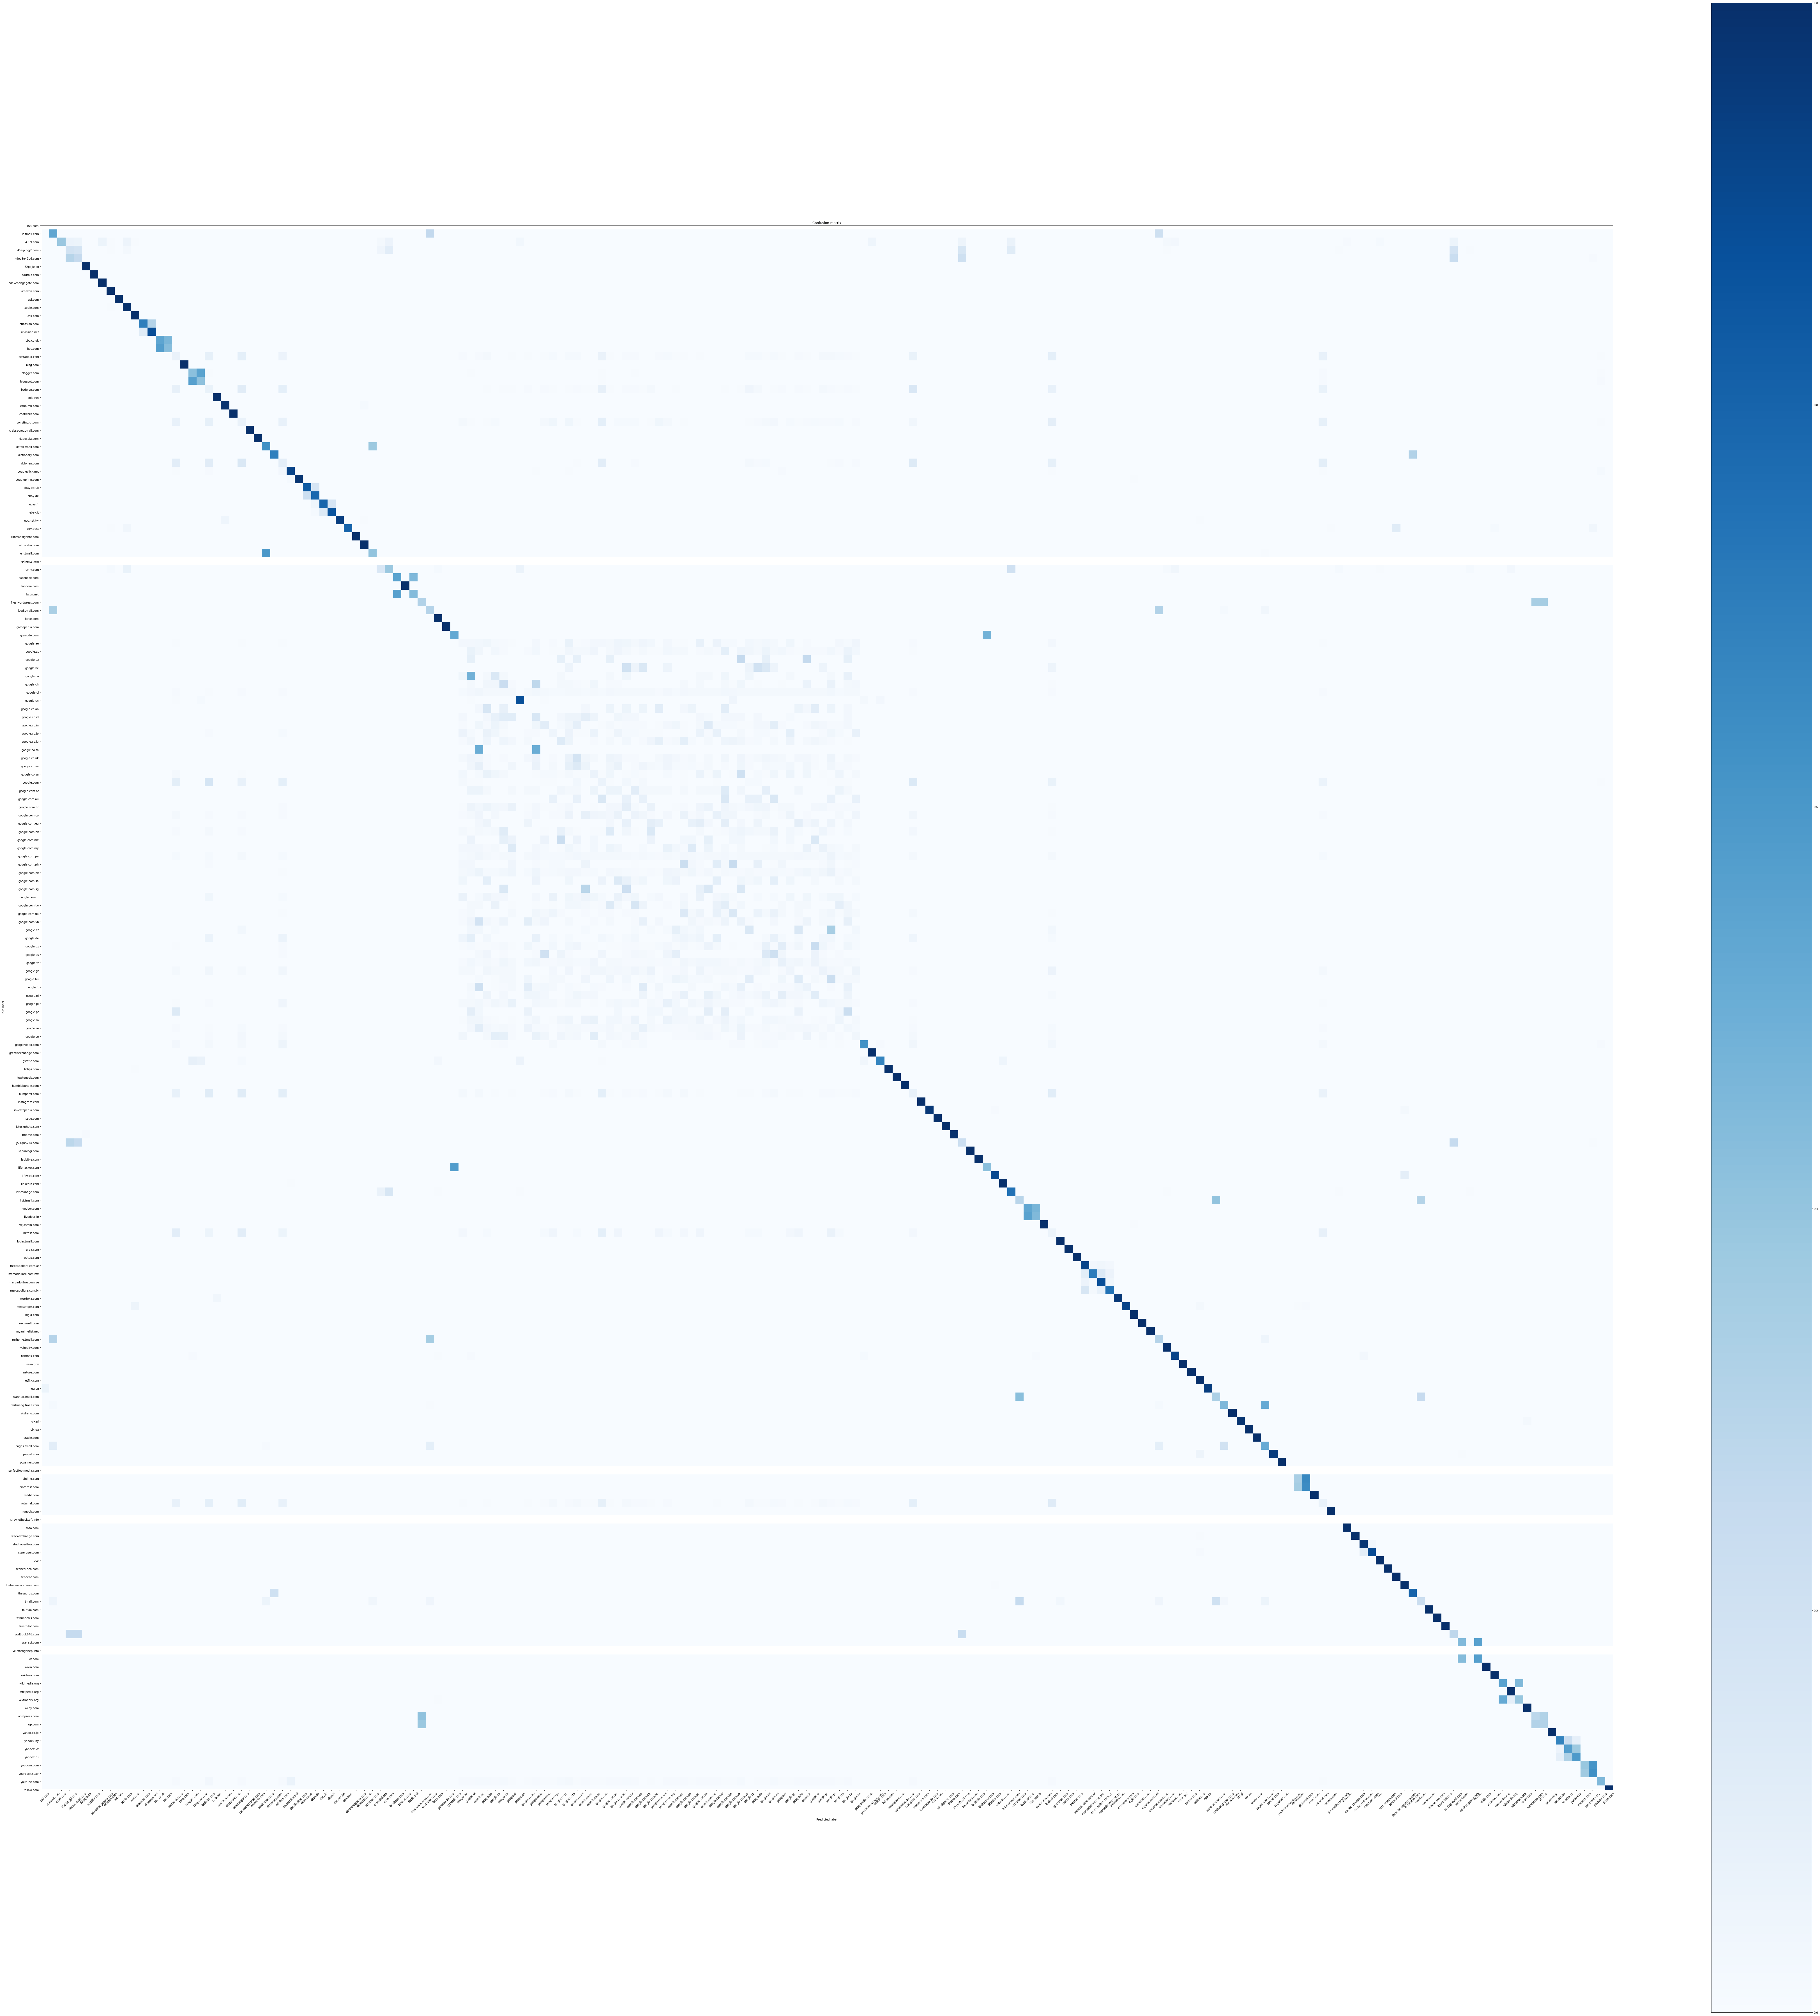

In [19]:
import itertools
print_conf_mat_info(conf_matrix_ip, output_size_ipdataset, le_labels.classes_)
print(le_labels.classes_, len(le_labels.classes_))
fig = plt.gcf()
fig.set_size_inches(100, 100)
fig.savefig("ip"+add_name+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix_ip, le_labels.classes_, "ip", True)

tensor([  0.,  33., 171.,  45.,  60., 233., 207., 184., 169., 198., 141., 174.,
        191., 123., 132.,  57.,  17., 234.,  99.,  72.,  12., 181., 226., 198.,
         14., 216., 162., 105., 134.,  26., 211., 198., 119., 155., 168., 145.,
        171., 126., 189., 158.,  89.,   0., 150.,  63., 261.,  92.,  30.,  87.,
        175., 215.,  48.,   5.,  12.,   0.,   0.,   8.,  42.,  21., 131.,   0.,
         13.,  23.,  12.,  28.,   0.,  22.,  13.,   8.,   8.,   3.,   0.,  20.,
          7.,   0.,  33.,   0.,  20.,  15.,  46.,  17.,   0.,   2.,   2.,  22.,
         26.,   8.,  10.,   0.,  16.,  26.,  44.,   5.,  28.,  18.,   9.,   8.,
          0.,   9.,  11.,   4., 221., 160., 135., 189., 189., 198.,  14., 108.,
        180., 171., 171.,  99.,  63., 234., 252.,  91., 231., 225., 118.,  53.,
         75.,  85., 189.,   4., 136., 162., 225., 146., 159., 185., 128., 234.,
        207., 169., 171., 270.,  47., 236., 183., 252., 207., 198., 161.,  83.,
         64., 180., 252., 270., 171., 14

Confusion matrix, without normalization
tensor([[  1.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,  26.,   0.,  ...,   0.,   0.,   0.],
        [  6.,   0., 198.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,  68.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,  95.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 189.]])


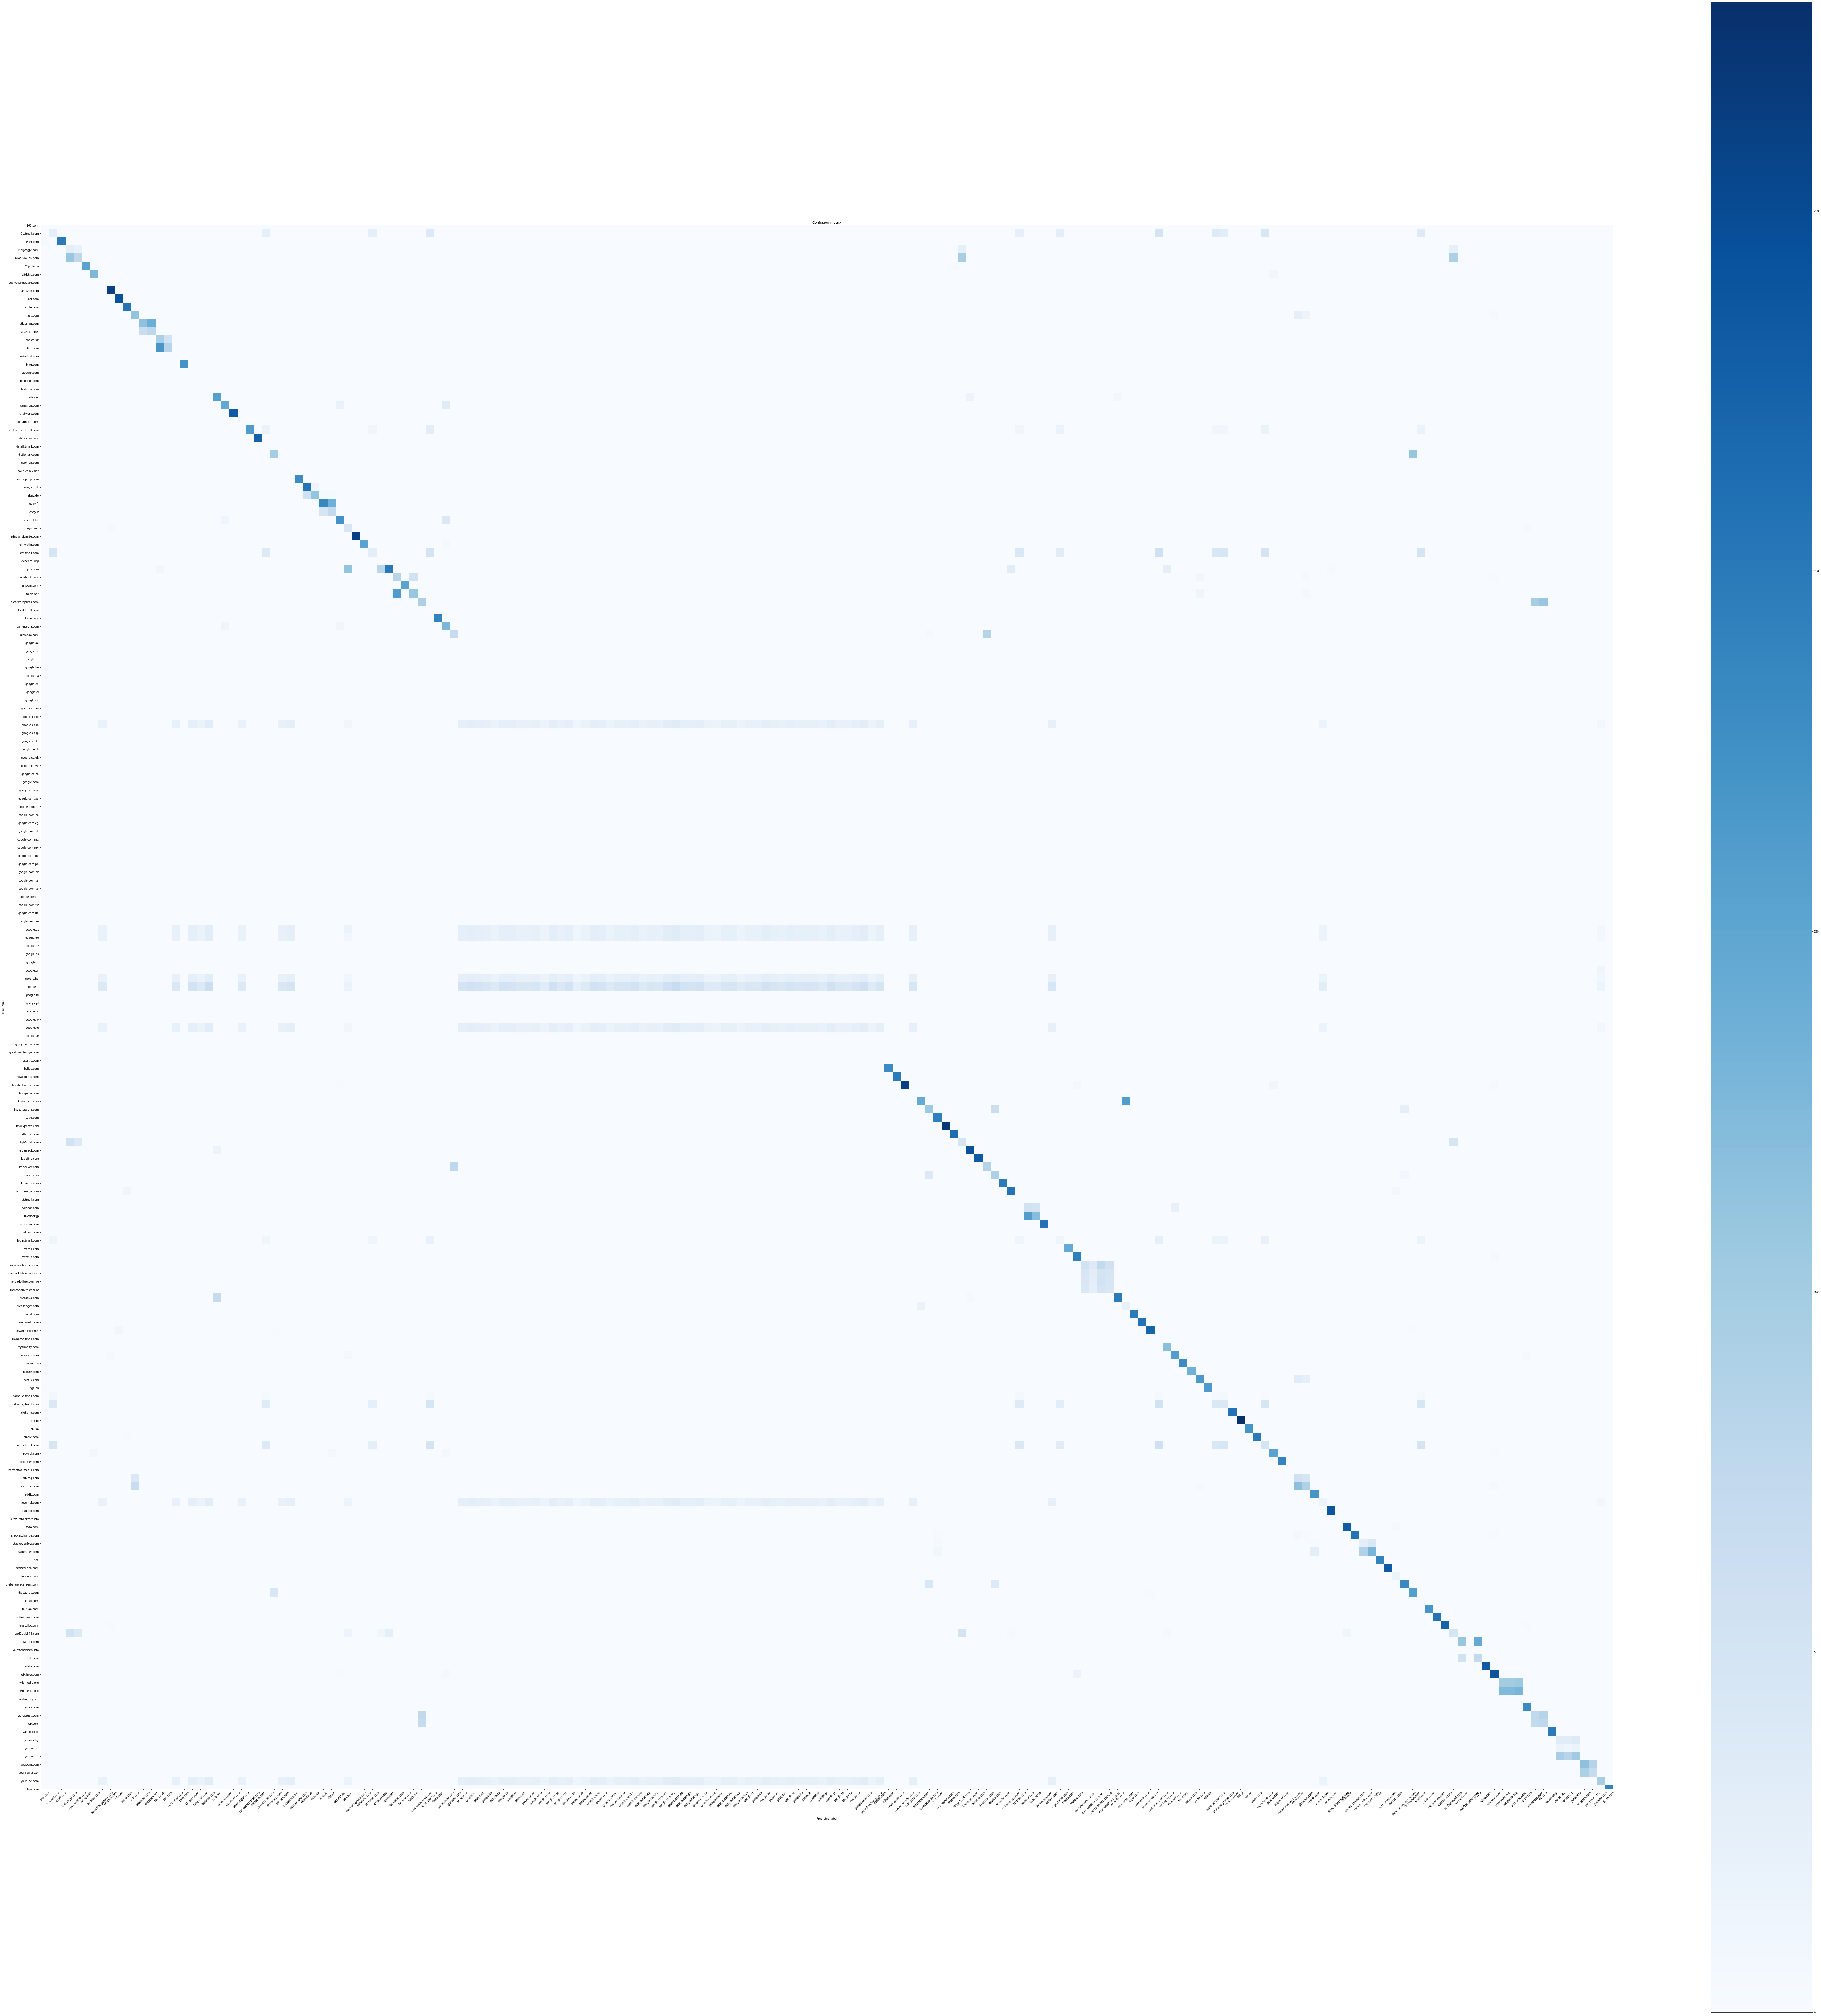

{'thebalancecareers.com': {'investopedia.com', 'thebalancecareers.com', 'lifewire.com'}, 'merdeka.com': {'merdeka.com', 'bola.net', 'kapanlagi.com'}, 'ebay.it': {'ebay.fr', 'ebay.de', 'ebay.it', 'paypal.com'}, 'tmall.com': {'err.tmall.com', 'nianhuo.tmall.com', 'crabsecret.tmall.com', 'login.tmall.com', 'pages.tmall.com', '3c.tmall.com', 'nvzhuang.tmall.com'}, 'humblebundle.com': {'humblebundle.com'}, 'google.ca': {'google.hu', 'google.de', 'youtube.com', 'google.ru', 'google.it', 'rotumal.com', 'google.co.in', 'google.cz'}, 'google.co.ve': {'google.hu', 'google.de', 'youtube.com', 'google.ru', 'google.it', 'rotumal.com', 'google.co.in', 'google.cz'}, 'google.at': {'google.hu', 'google.de', 'youtube.com', 'google.ru', 'google.it', 'rotumal.com', 'google.co.in', 'google.cz'}, 'wp.com': {'files.wordpress.com', 'wordpress.com', 'wp.com'}, 'constintptr.com': {'google.hu', 'google.de', 'youtube.com', 'google.ru', 'google.it', 'rotumal.com', 'google.co.in', 'google.cz'}, '45eijvhgj2.com': {'

In [20]:
print(conf_matrix_ip.diag())

print(labels_to_predicted_ip)

fig = plt.gcf()
fig.set_size_inches(100, 100)
fig.savefig("asn"+add_name+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix, le_labels.classes_, "asn", False)

print(labels_to_predicted_asn)

In [21]:
import json

for key in labels_to_predicted_ip:
    labels_to_predicted_ip[key] = list(labels_to_predicted_ip[key])
    
for key in labels_to_predicted_asn:
    labels_to_predicted_asn[key] = list(labels_to_predicted_asn[key])
    
with open('ip'+add_name+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_ip, json_file)

with open('asn'+add_name+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_asn, json_file)

In [22]:
clusters = dict()

In [23]:
clusters.setdefault("google.com", set())
clusters.setdefault("non_google", set())

for label in labels_to_predicted_ip:
    if "google" in label:
        clusters["google.com"].add(label)
        predicted = labels_to_predicted_ip[label]
        for pred in predicted:
            if "google" in pred:
                clusters["google.com"].add(pred)
print(clusters)
                
# google_list = ["google.ca","google.dz","google.co.in","google.com.pk","google.cz",
#                "google.com.eg","google.com.vn","google.co.ve","google.co.uk",
#                "google.hu","google.co.jp","google.ru","google.gr","google.co.ao",
#                "google.com.sg","google.com.br","google.co.za","google.co.th",
#                "google.com.my","google.cl","google.it","google.ch","google.com.ph",
#                "google.pt","google.com.ua","google.az","google.fr","google.com.pe",
#                "google.ro","google.com.tw","google.com","google.co.kr","google.be",
#                "google.de","google.cn","google.com.co","google.com.hk","google.com.mx",
#                "google.pl","google.gr","google.at","google.ae","google.es","google.com.ar",
#                "google.co.th","google.com.my","google.com.au","google.ro","google.ch",
#                "google.com.tr",]
# other_in_google = ["rotumal.com","lnkfast.com","dolohen.com"]


{'google.com': {'google.at', 'google.com.tr', 'google.es', 'google.com.hk', 'google.ro', 'google.fr', 'google.ch', 'google.se', 'google.cz', 'google.co.jp', 'google.ca', 'google.co.ao', 'google.pl', 'google.be', 'google.nl', 'google.com.ph', 'google.pt', 'google.com.eg', 'google.com.vn', 'google.co.ve', 'google.com.ua', 'google.gr', 'google.dz', 'googlevideo.com', 'google.hu', 'google.az', 'google.com.pk', 'google.com.pe', 'google.com.au', 'google.co.id', 'google.co.uk', 'google.co.kr', 'google.it', 'google.cn', 'google.com.mx', 'google.co.in', 'google.com.co', 'google.com.sg', 'google.com.ar', 'google.com', 'google.de', 'google.com.tw', 'google.ru', 'google.ae', 'google.com.my', 'google.co.za', 'google.cl', 'google.com.sa', 'google.co.th', 'google.com.br'}, 'non_google': set()}


In [24]:
wiki_list = ["wiktionary.org","wikimedia.org"]

tmall_list = ["list-manage.com","food.tmall.com","myhome.tmall.com",
              "3c.tmall.com","nvzhuang.tmall.com","pages.tmall.com","err.tmall.com",
              "detail.tmall.com", "tmall.com","list.tmall.com","nianhuo.tmall.com",
              "login.tmall.com","crabsecret.tmall.com"]

mercadolibre_list = ["mercadolivre.com.br","mercadolibre.com.ve",
                     "mercadolibre.com.ar","mercadolibre.com.mx"]

investopedia_list = ["investopedia.com","lifewire.com"]

yourporn_list = ["yourporn.sexy","youporn.com"]

yandex_list = ["yandex.ru","yandex.kz","yandex.by","yandex.kz"]

pinterest_list = ["pinimg.com","pinterest.com"]

doubleclick_list = ["youtube.com","doubleclick.net"]
        
bbc_list = ["bbc.com","bbc.co.uk"]

ebay_list = ["ebay.fr","ebay.co.uk","ebay.de"]
  
wordpress_list = ["wp.com","files.wordpress.com","wordpress.com"]

dictionary_list = ["thesaurus.com","dictionary.com"]

thesaurus_list = ["thesaurus.com","dictionary.com"]

rotumal_list = ["google.ca","bodelen.com","google.com.tw","rotumal.com",
                "bestadbid.com","google.com.eg","google.com","lnkfast.com",
                "google.nl","google.co.uk","google.com.co","google.com.hk",
                "google.co.jp","google.com.sa","google.gr","google.ae",
                "constintptr.com","google.com.br","google.es","google.com.ar",
                "google.co.th","google.com.au","google.cl","humparsi.com",
                "dolohen.com","google.pt"]

uod2quk646_list = ["45eijvhgj2.com","49oa3o49b6.com","jf71qh5v14.com","uod2quk646.com"]
  
bestadbid_list = ["bodelen.com","constintptr.com","humparsi.com","rotumal.com",
                  "dolohen.com","bestadbid.com","google.com.sa","google.com",
                  "google.cl","google.com.au","lnkfast.com"]

wiley_list = ["egy.best","olx.pl","wiley.com"]
    
myshopify_list =  ["myshopify.com","eyny.com"]
    
blogger_list = ["blogspot.com","eyny.com","blogger.com"]

humparsi_list = ["google.ca","bodelen.com","google.com.tw","rotumal.com","googlevideo.com",
                 "bestadbid.com","google.com","lnkfast.com","google.be",
                 "google.de","google.com.co","google.com.hk","google.co.jp","google.pl",
                 "constintptr.com","google.com.au","google.se","humparsi.com",
                 "dolohen.com","google.com.tr"]

atlassian_list = ["atlassian.com","atlassian.net"]

exhentai_list = ["eyny.com"]

livedoor_list = ["livedoor.com","livedoor.jp"]

fb_list = ["fbcdn.net","facebook.com"] #,"gstatic.com"]

apple_list = ["apple.com","eyny.com"]

stackoverflow_list = ["stackoverflow.com","superuser.com"]

lifehacker_list = ["gizmodo.com","lifehacker.com"]

gstatic_list = ["googlevideo.com","google.cn","gstatic.com"]



In [25]:
# combine a couple clusters
clusters["tmall"] = set(tmall_list)
clusters["wp"] = set(wordpress_list)
clusters["fb"] = set(fb_list)
clusters["ebay"] = set(ebay_list)
clusters["bbc"] = set(bbc_list)

In [26]:
print(clusters)

{'google.com': {'google.at', 'google.com.tr', 'google.es', 'google.com.hk', 'google.ro', 'google.fr', 'google.ch', 'google.se', 'google.cz', 'google.co.jp', 'google.ca', 'google.co.ao', 'google.pl', 'google.be', 'google.nl', 'google.com.ph', 'google.pt', 'google.com.eg', 'google.com.vn', 'google.co.ve', 'google.com.ua', 'google.gr', 'google.dz', 'googlevideo.com', 'google.hu', 'google.az', 'google.com.pk', 'google.com.pe', 'google.com.au', 'google.co.id', 'google.co.uk', 'google.co.kr', 'google.it', 'google.cn', 'google.com.mx', 'google.co.in', 'google.com.co', 'google.com.sg', 'google.com.ar', 'google.com', 'google.de', 'google.com.tw', 'google.ru', 'google.ae', 'google.com.my', 'google.co.za', 'google.cl', 'google.com.sa', 'google.co.th', 'google.com.br'}, 'non_google': set(), 'tmall': {'err.tmall.com', 'list.tmall.com', 'nianhuo.tmall.com', 'list-manage.com', 'food.tmall.com', 'login.tmall.com', 'pages.tmall.com', 'crabsecret.tmall.com', '3c.tmall.com', 'tmall.com', 'nvzhuang.tmall.

In [27]:
with open('mapping_top5_ip_'+add_name+str(datetime.date(datetime.now()))+".txt", "w") as f:
    for i in range(len(top_elems_list_ip)):
        f.write(str(top_elems_list_ip[i])+":"+str(corresponding_target_ip[i])+"\n")

with open('mapping_top5_asn_'+add_name+str(datetime.date(datetime.now()))+".txt", "w") as f:
    for i in range(len(top_elems_list_asn)):
        f.write(str(top_elems_list_asn[i])+":"+str(corresponding_target_asn[i])+"\n")

In [28]:
site_to_replacement = dict()
for cluster_label in clusters:
    cluster_elems = clusters[cluster_label]
    for site_to_replace in cluster_elems:
        site_to_replacement[site_to_replace] = cluster_label

In [29]:
labels_new = labels
print(len(set(labels_new)))
for i in range(len(labels)):
    try:
        labels_new[i] = site_to_replacement[labels[i]]
    except KeyError:
        continue

print(len(set(labels_new)))

192
125


In [30]:
print(len(labels_new), len(encodings))

20785 20785


In [31]:
sites_asn_new = sites_asn
print(len(sites_asn_new))
for i in range(len(sites_asn)):
    try:
        sites_asn_new[i] = site_to_replacement[sites_asn[i]]
    except KeyError:
        continue

print(len(sites_asn_new))

20785
20785


In [32]:
print(len(set(sites_asn_new)))

125


In [33]:
from sklearn import preprocessing
import torch

tensor_encodings = torch.Tensor(encodings)
le_labels = preprocessing.LabelEncoder()
tensor_labels = le_labels.fit_transform(labels_new)
tensor_labels = torch.as_tensor(tensor_labels)

tensor_asn_enc = torch.Tensor(asn_enc)
le_asn = preprocessing.LabelEncoder()
tensor_sites_asn = le_asn.fit_transform(sites_asn_new)
tensor_sites_asn = torch.as_tensor(tensor_sites_asn)

In [34]:
import torch.utils.data as data

ip_dataset = data.TensorDataset(tensor_encodings,tensor_labels)
asn_dataset = data.TensorDataset(tensor_asn_enc,tensor_sites_asn)

batch_size = 64
validation_split = .2
# shuffle_dataset = True
shuffle_dataset = False
# random_seed= 42

train_size = int(0.8 * len(asn_dataset))
test_size = len(asn_dataset) - train_size
asn_train_dataset, asn_test_dataset = torch.utils.data.random_split(asn_dataset, [train_size, test_size])
asn_train_loader = torch.utils.data.DataLoader(asn_train_dataset, batch_size=batch_size, shuffle=True)
asn_test_loader = torch.utils.data.DataLoader(asn_test_dataset, batch_size=batch_size, shuffle=True)
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))

train_size = int(0.8 * len(ip_dataset))
test_size = len(ip_dataset) - train_size
ip_train_dataset, ip_test_dataset = torch.utils.data.random_split(ip_dataset, [train_size, test_size])
ip_train_loader = torch.utils.data.DataLoader(ip_train_dataset, batch_size=batch_size, shuffle=True)
ip_test_loader = torch.utils.data.DataLoader(ip_test_dataset, batch_size=batch_size, shuffle=True)
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))

print (len(ip_train_loader)) 
print (len(ip_test_loader))

input_size_ipdataset = len(tensor_encodings[0])
output_size_ipdataset = len(set(labels_new))
embed_size_ipdataset = 1000

input_size_asndataset = len(tensor_asn_enc[0])
output_size_asndataset = len(set(sites_asn_new))
embed_size_asndataset = 270
print(input_size_ipdataset, output_size_ipdataset)
print(input_size_asndataset, output_size_asndataset)

model_ip = NNet(input_size_ipdataset, output_size_ipdataset)
model_asn = NNet(input_size_asndataset, output_size_asndataset)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer_ip = torch.optim.SGD(model_ip.parameters(), lr=0.5)
optimizer_asn = torch.optim.SGD(model_asn.parameters(), lr=0.5)

len(ip_test_loader.dataset)

16628 4157
16628 4157
260
65
9760 125
346 125


4157

In [35]:
# Reference: https://github.com/hunkim/PyTorchZeroToAll

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import time
device = 'cpu'

def confusion_mat(preds, labels, conf_matrix, labels_to_predicted):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        t_class = le_labels.classes_[t.item()]
        p_class = le_labels.classes_[p.item()]
        labels_to_predicted.setdefault(t_class, set())
        labels_to_predicted[t_class].add(p_class)
        conf_matrix[p, t] += 1
    
    return conf_matrix

def train(epoch, train_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() 
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return total_loss / len(train_loader)

def test(test_loader, model, conf_matrix, labels_to_predicted, top_elems_list, corresponding_target):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        conf_matrix = confusion_mat(output, target, conf_matrix, labels_to_predicted)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        top5 = torch.topk(output,5,1)[1]
        top_elems_list.extend(le_labels.classes_[top5.tolist()])
        corresponding_target.extend(le_labels.classes_[target.tolist()])
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss
    
    

In [36]:
# first ip dataset training and tests
since = time.time()
labels_to_predicted_ip = dict()
top_elems_list_ip = []
corresponding_target_ip = []
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))
conf_matrix_ip = torch.zeros(output_size_ipdataset, output_size_ipdataset)
train_losses, test_losses = [], []
for epoch in range(1, 10):
    epoch_start = time.time()
    epoch_train_loss = train(epoch, ip_train_loader, model_ip, optimizer_ip)
    train_losses.append(epoch_train_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    epoch_test_loss = test(ip_test_loader, model_ip, conf_matrix_ip, 
                           labels_to_predicted_ip, top_elems_list_ip, corresponding_target_ip)
    test_losses.append(epoch_test_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

print("conf mat ip: ", conf_matrix_ip)

16628 4157
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 4.828432
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 3.740429
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 3.353605
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 3.445873
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 3.539436
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 2.517461
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 2.710016
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 2.965589
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 2.489733
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 2.511489
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 2.527586
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 2.256930
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 2.310559
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 2.157884
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 1.749961
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 8960/16628 (54%) | Loss: 0.339626
Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 0.399132
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 0.177921
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 0.381623
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 0.360822
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 0.237873
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 0.276811
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 0.225727
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 0.165861
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 0.361100
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 0.307435
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 0.315325
Training time: 0m 9s
Test set: Average loss: 0.3646, Accuracy: 3685/4157 (89%)
Testing time: 0m 10s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 0.162420
Train Epoch: 6 | Batch Status: 640/16628 (4%) | L

In [37]:
# Now asn dataset training and tests
since = time.time()
criterion = nn.CrossEntropyLoss(reduction='mean')
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))
conf_matrix = torch.zeros(output_size_ipdataset, output_size_ipdataset)
labels_to_predicted_asn = dict()
top_elems_list_asn = []
corresponding_target_asn = []

import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, name, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+"_new_"+add_name+str(datetime.date(datetime.now()))+".png")
    plt.show()
    
for epoch in range(1, 10):
    epoch_start = time.time()
    train(epoch, asn_train_loader, model_asn, optimizer_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    test(asn_test_loader, model_asn, conf_matrix, labels_to_predicted_asn, 
         top_elems_list_asn, corresponding_target_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')
print("conf mat asn: ", conf_matrix)

16628 4157
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 4.819332
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 3.479161
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 3.201437
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 3.715181
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 3.059643
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 2.675788
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 3.252523
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 2.425658
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 2.738550
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 2.451104
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 2.631940
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 2.219603
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 2.273001
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 1.758038
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 2.257980
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 0.478185
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 0.744836
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 0.818683
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 0.643323
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 0.663152
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 0.575100
Training time: 0m 1s
Test set: Average loss: 0.7224, Accuracy: 3259/4157 (78%)
Testing time: 0m 1s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 0.476779
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Loss: 0.655235
Train Epoch: 6 | Batch Status: 1280/16628 (8%) | Loss: 0.728100
Train Epoch: 6 | Batch Status: 1920/16628 (12%) | Loss: 0.375531
Train Epoch: 6 | Batch Status: 2560/16628 (15%) | Loss: 0.705784
Train Epoch: 6 | Batch Status: 3200/16628 (19%) | Loss: 0.446084
Train Epoch: 6 | Batch Status: 3840/16628 (23%) | Loss: 0.386718
Train Epoch: 6 | Batch Status: 4480/16628 (27%) | Loss: 0

In [38]:
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+"_new_"+add_name+str(datetime.date(datetime.now()))+".png")
    plt.show()

In [39]:
def print_conf_mat_info(conf_matrix, n_classes, labels):
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).bool()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        sensitivity = (TP[c] / (TP[c]+FN))
        specificity = (TN / (TN+FP))

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            labels[c], TP[c], TN, FP, FN))
        print('Sensitivity = {}'.format(sensitivity))
        print('Specificity = {}'.format(specificity))

Class 163.com
TP 0.0, TN 37413.0, FP 0.0, FN 0.0
Sensitivity = nan
Specificity = 1.0
Class 4399.com
TP 180.0, TN 36975.0, FP 258.0, FN 0.0
Sensitivity = 1.0
Specificity = 0.993070662021637
Class 45eijvhgj2.com
TP 41.0, TN 37094.0, FP 130.0, FN 148.0
Sensitivity = 0.21693122386932373
Specificity = 0.9965076446533203
Class 49oa3o49b6.com
TP 51.0, TN 37083.0, FP 123.0, FN 156.0
Sensitivity = 0.24637681245803833
Specificity = 0.9966940879821777
Class 52pojie.cn
TP 144.0, TN 37269.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class addthis.com
TP 169.0, TN 37242.0, FP 0.0, FN 2.0
Sensitivity = 0.988304078578949
Specificity = 1.0
Class adexchangegate.com
TP 198.0, TN 37215.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class amazon.com
TP 232.0, TN 37179.0, FP 0.0, FN 2.0
Sensitivity = 0.9914529919624329
Specificity = 1.0
Class aol.com
TP 225.0, TN 37188.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class apple.com
TP 142.0, TN 37228.0, FP 5.0, FN 38.0
Sensitivity = 0.

Normalized confusion matrix
tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.0000, 0.4110, 0.0479,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2398,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4322, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9516, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


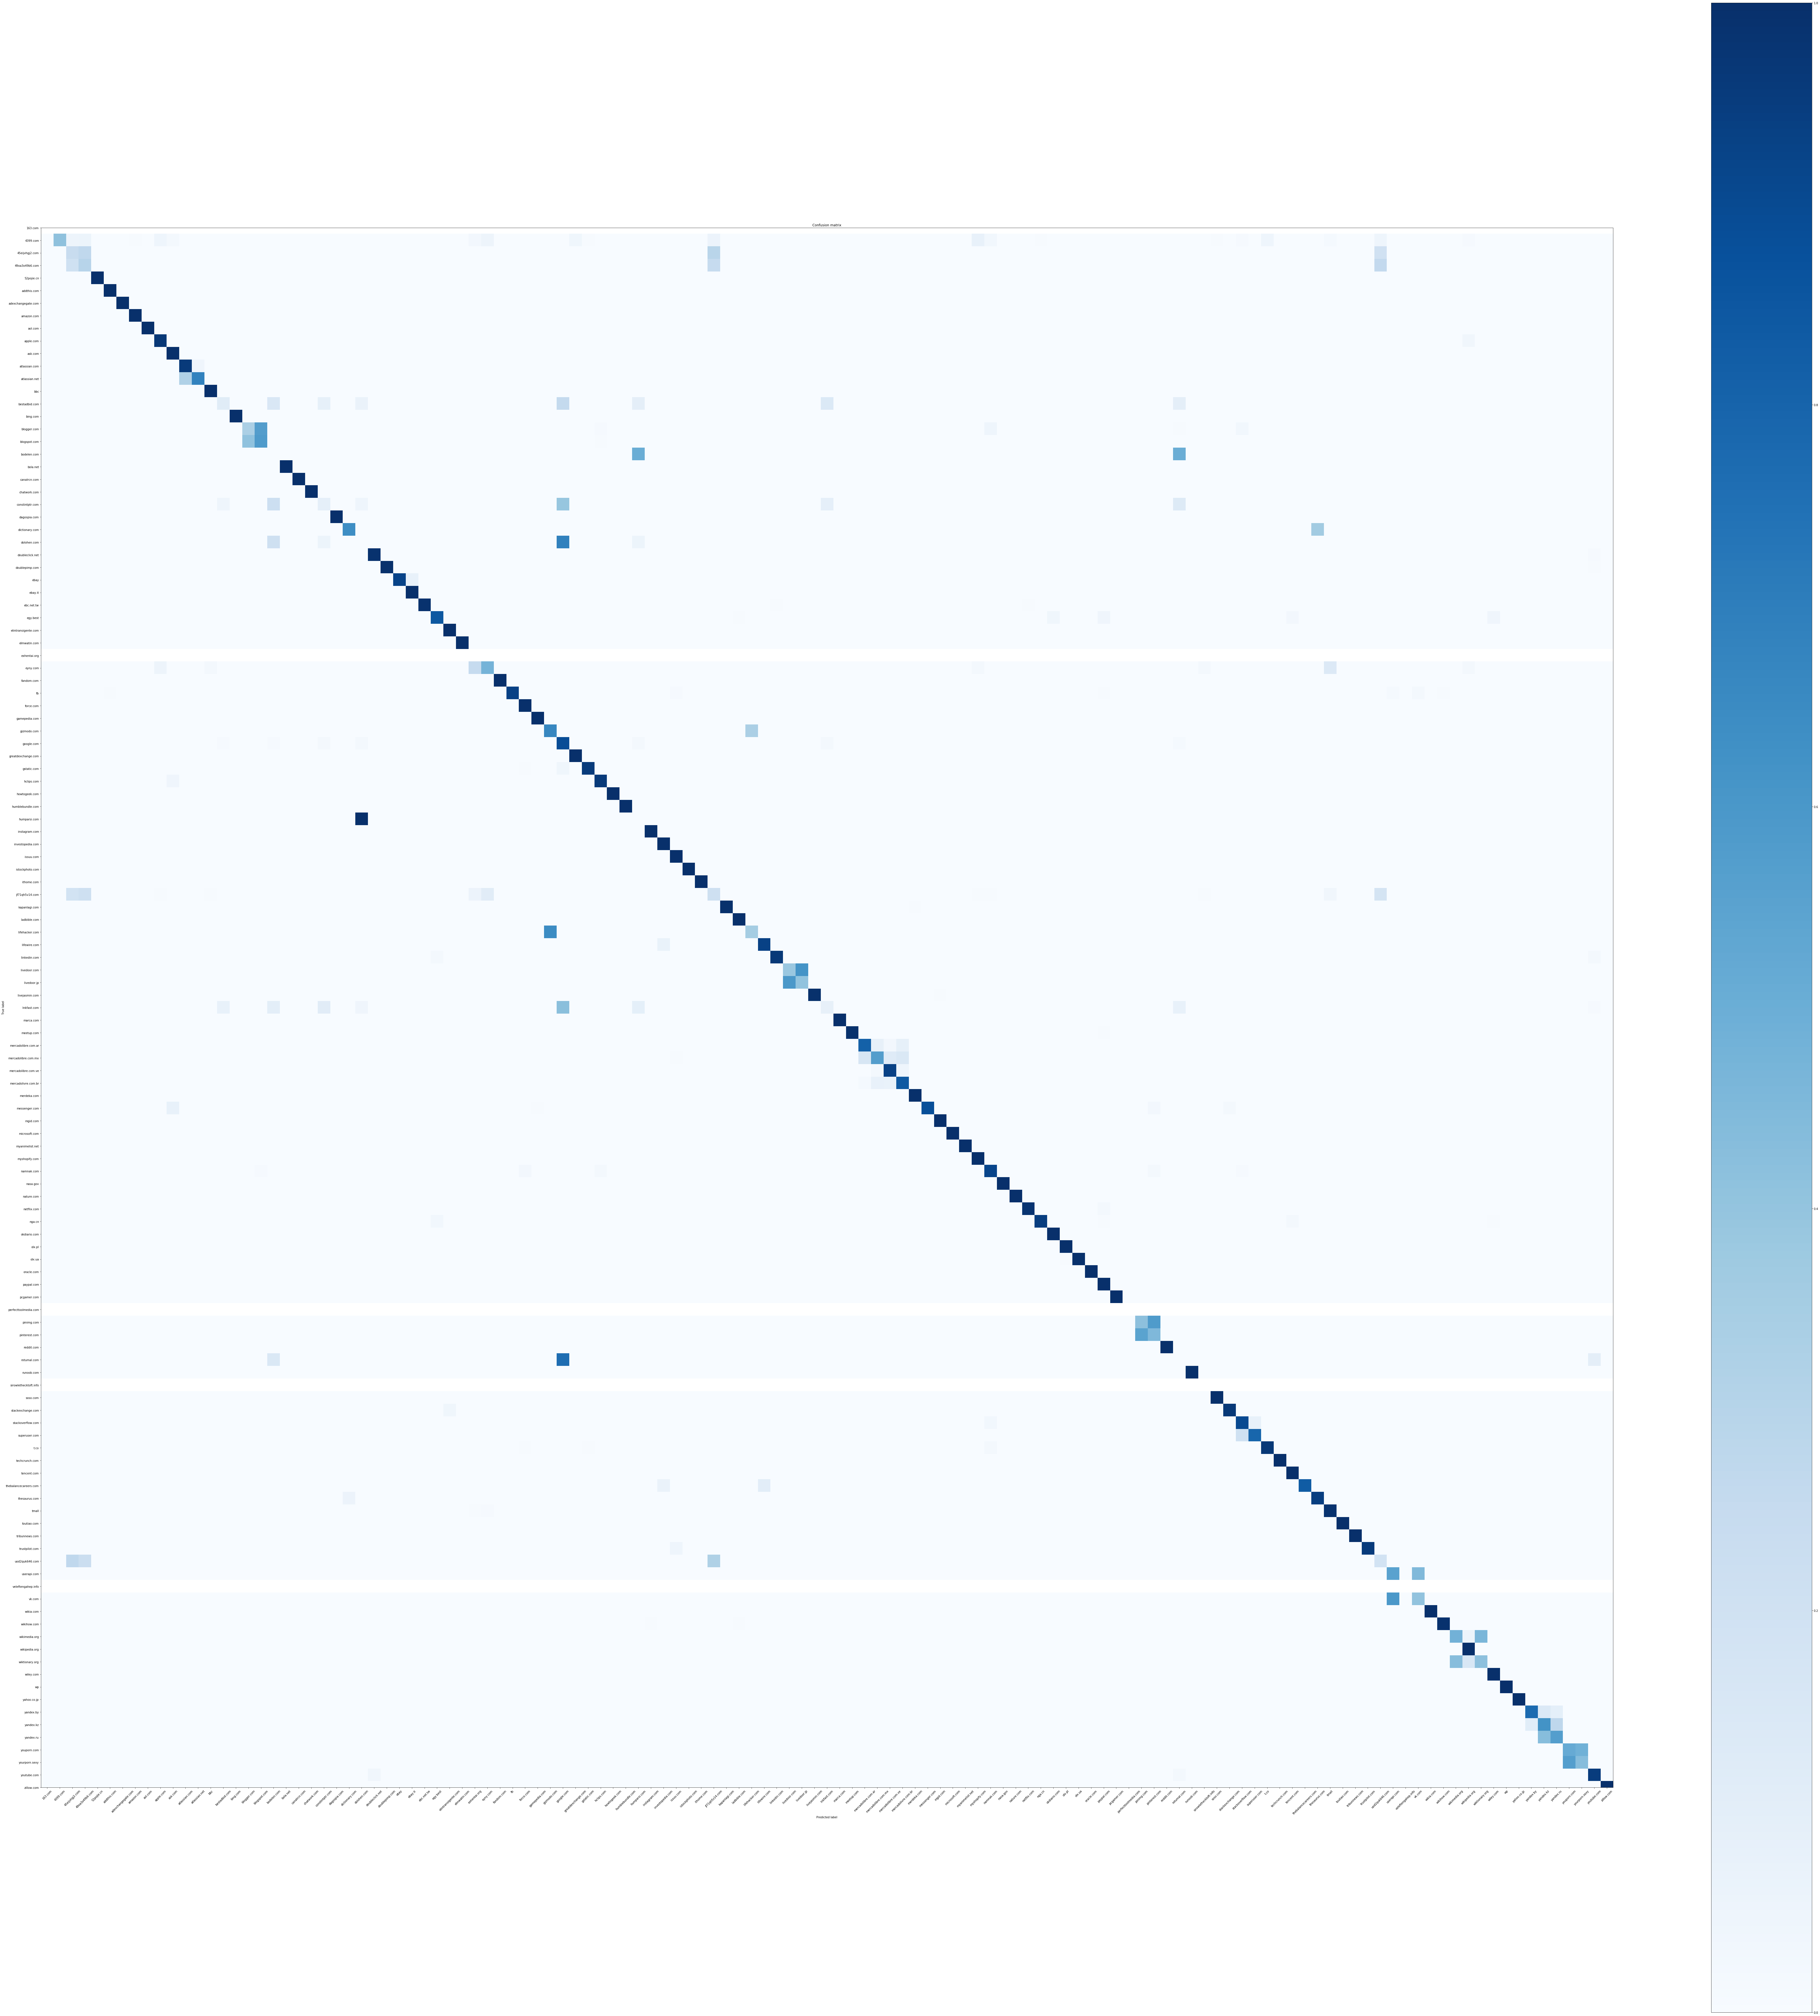

In [40]:
import itertools
print_conf_mat_info(conf_matrix_ip, output_size_ipdataset, le_labels.classes_)
print(le_labels.classes_, len(le_labels.classes_))
fig = plt.gcf()
fig.set_size_inches(100, 100)
fig.savefig("ip_new_"+add_name+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix_ip, le_labels.classes_, "ip", True)

tensor([0.0000e+00, 1.8000e+02, 4.1000e+01, 5.1000e+01, 1.4400e+02, 1.6900e+02,
        1.9800e+02, 2.3200e+02, 2.2500e+02, 1.4200e+02, 2.4100e+02, 1.4000e+02,
        1.8300e+02, 2.8800e+02, 1.1000e+01, 1.7100e+02, 5.9000e+01, 8.6000e+01,
        0.0000e+00, 1.6200e+02, 1.7100e+02, 1.9800e+02, 2.0000e+00, 1.6200e+02,
        1.8100e+02, 0.0000e+00, 1.9900e+02, 1.6200e+02, 5.0400e+02, 1.9300e+02,
        2.5200e+02, 1.6000e+02, 1.8000e+02, 9.9000e+01, 0.0000e+00, 1.2600e+02,
        1.8900e+02, 3.6000e+02, 1.3500e+02, 1.5200e+02, 9.7000e+01, 1.0357e+04,
        1.3600e+02, 1.5200e+02, 2.0700e+02, 2.2500e+02, 1.5300e+02, 0.0000e+00,
        1.4300e+02, 1.4700e+02, 2.2000e+02, 1.8900e+02, 1.6200e+02, 3.9000e+01,
        1.6200e+02, 2.7700e+02, 1.0400e+02, 1.6100e+02, 2.3300e+02, 1.0600e+02,
        5.6000e+01, 1.9800e+02, 8.0000e+00, 1.8900e+02, 2.0700e+02, 1.9200e+02,
        1.0900e+02, 1.6700e+02, 1.3400e+02, 1.8800e+02, 1.6200e+02, 1.3400e+02,
        2.3400e+02, 2.9700e+02, 2.6400e+

Normalized confusion matrix
tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.0000, 0.9631, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2449,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4624, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9387]])


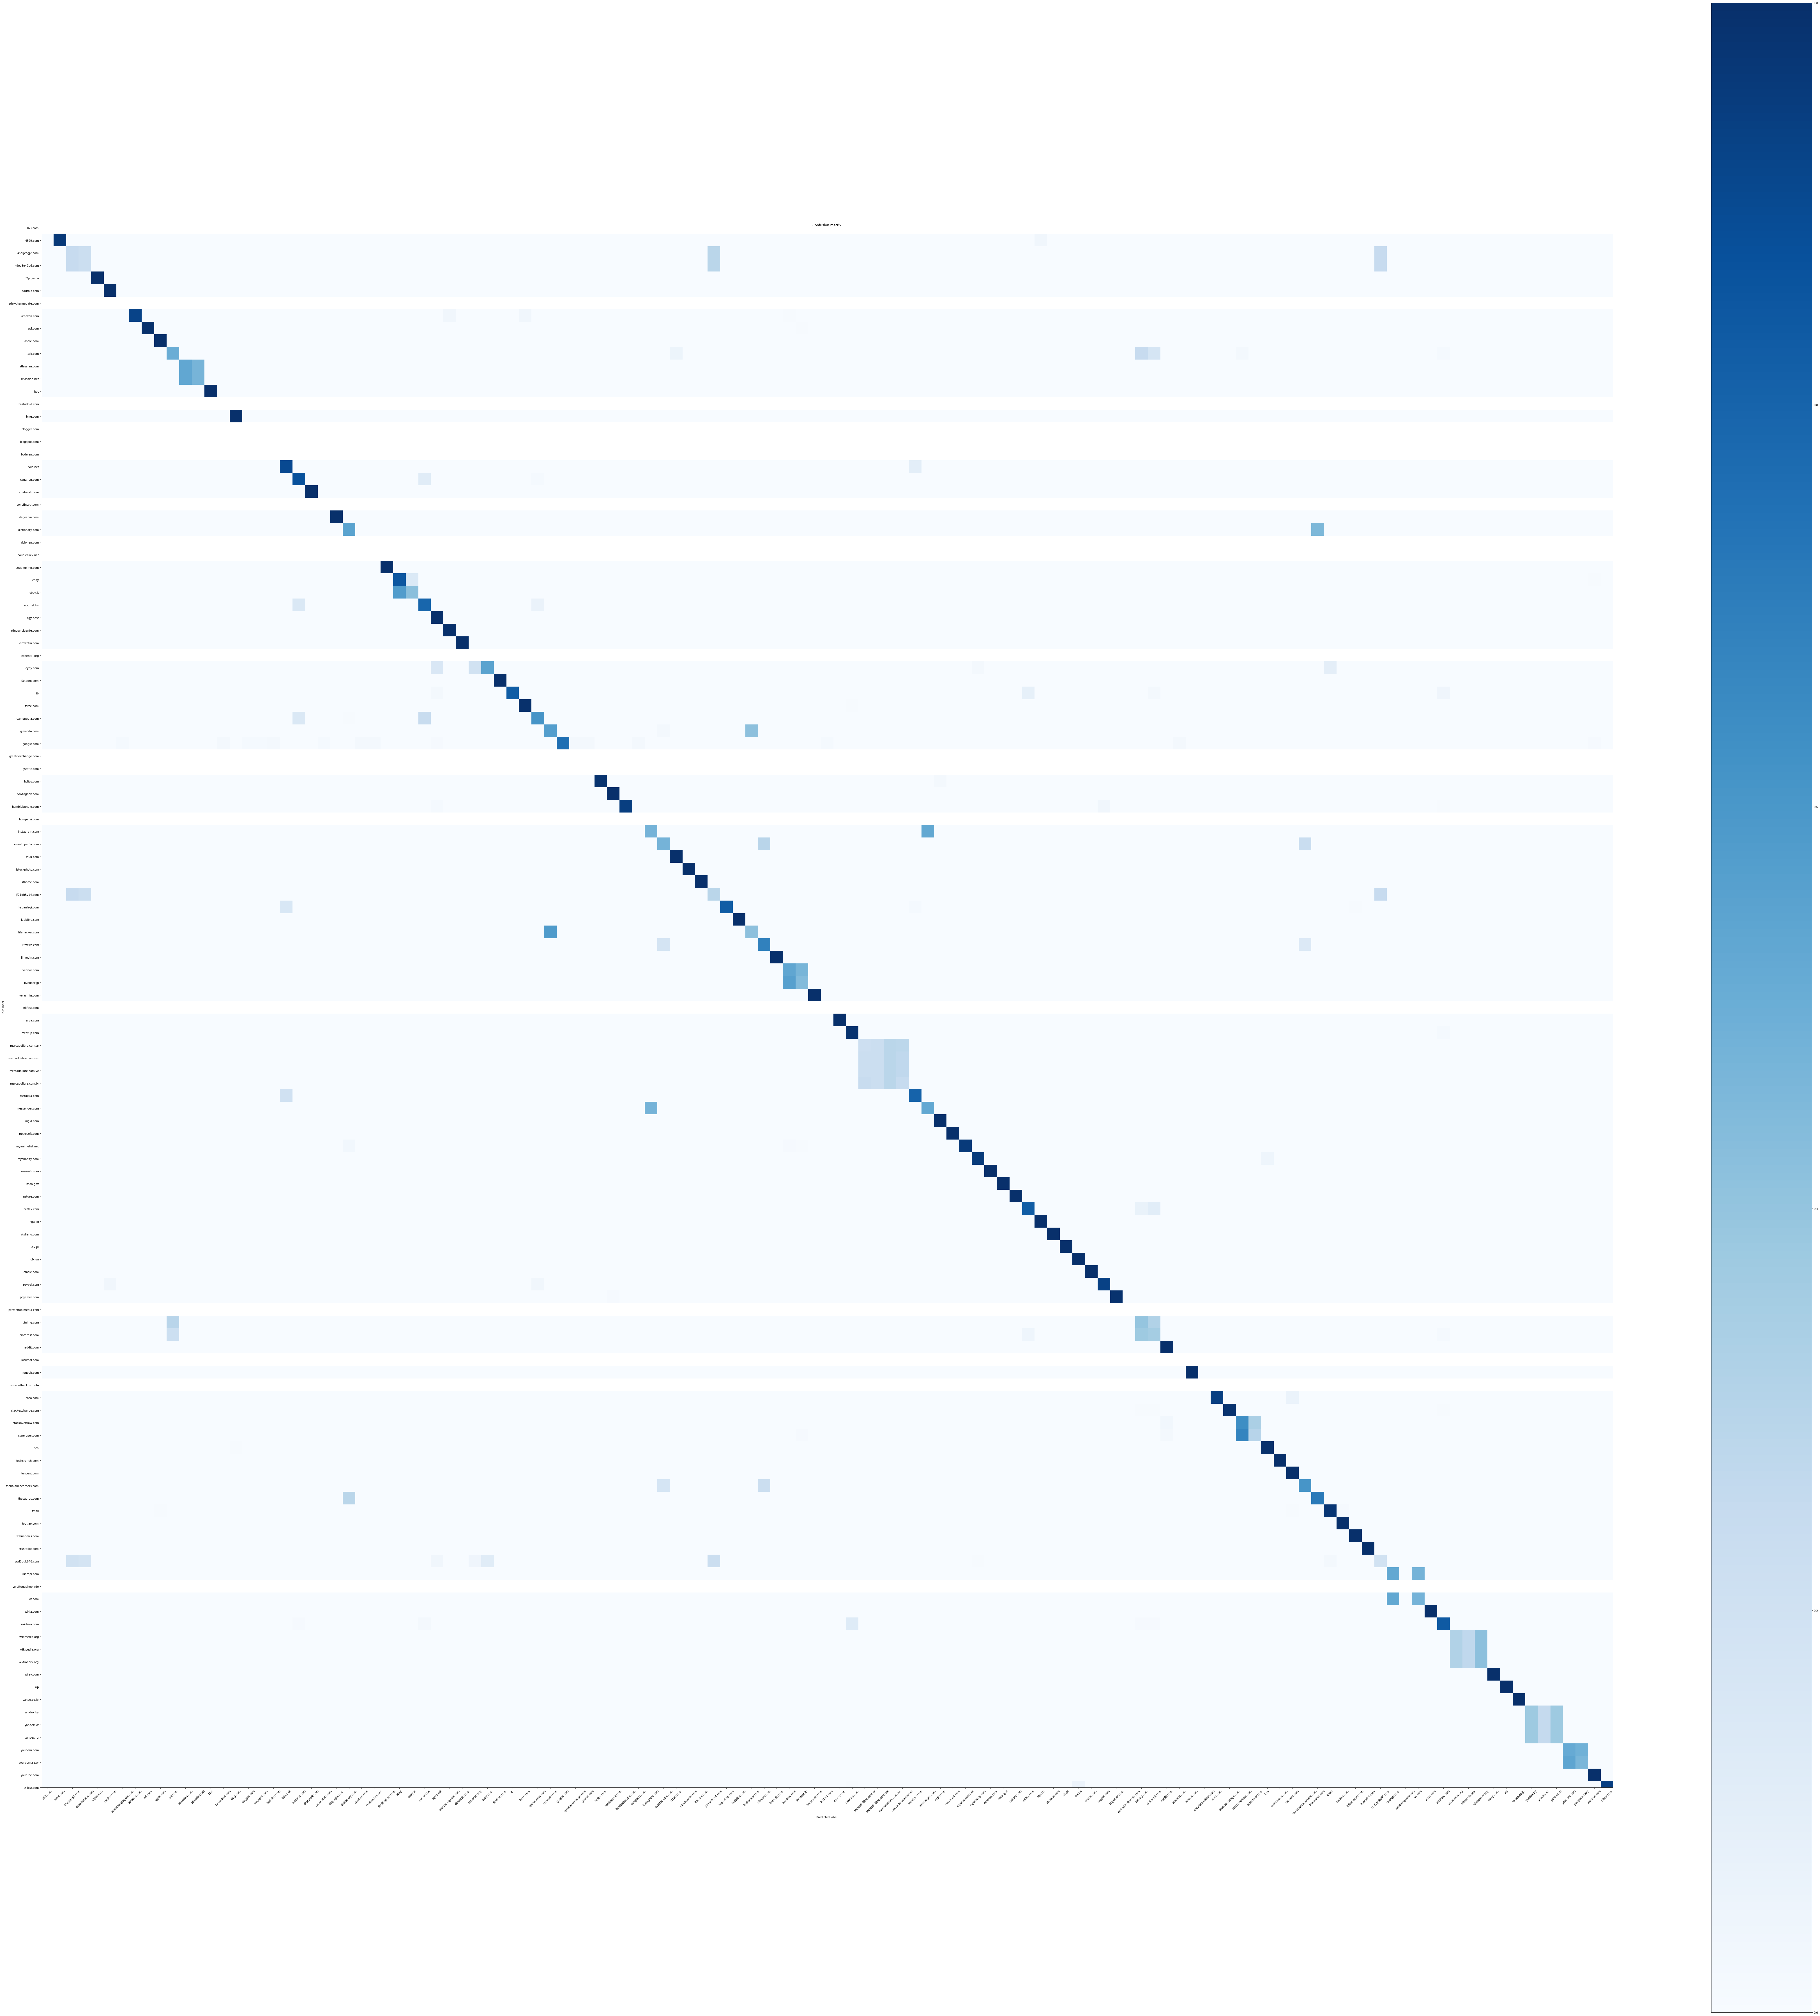

{'elmwatin.com': {'elmwatin.com'}, 'google.com': {'google.com'}, 'apple.com': {'apple.com', 'tmall'}, 'okdiario.com': {'google.com', 'okdiario.com'}, 'gamepedia.com': {'gamepedia.com', 'canalrcn.com', 'ebc.net.tw', 'paypal.com'}, 'nature.com': {'nature.com'}, 'pinterest.com': {'wikihow.com', 'pinterest.com', 'stackexchange.com', 'fb', 'pinimg.com', 'netflix.com', 'ask.com'}, 'yandex.ru': {'google.com', 'yandex.by', 'yandex.kz', 'yandex.ru'}, 'superuser.com': {'stackoverflow.com', 'superuser.com', 'ask.com'}, 'soso.com': {'soso.com'}, 'livejasmin.com': {'livejasmin.com'}, 'tmall': {'uod2quk646.com', 'eyny.com', 'tmall'}, 'amazon.com': {'amazon.com'}, 'investopedia.com': {'lifewire.com', 'investopedia.com', 'thebalancecareers.com', 'gizmodo.com'}, 'greatdexchange.com': {'google.com'}, 'nga.cn': {'nga.cn', '4399.com'}, 'lifewire.com': {'lifewire.com', 'investopedia.com', 'thebalancecareers.com'}, 'dictionary.com': {'gamepedia.com', 'dictionary.com', 'myanimelist.net', 'thesaurus.com'}, 'm

In [41]:
print(conf_matrix_ip.diag())

print(labels_to_predicted_ip)

fig = plt.gcf()
fig.set_size_inches(100, 100)
fig.savefig("asn_new_"+add_name+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix, le_labels.classes_, "asn", True)

print(labels_to_predicted_asn)

In [42]:
import json

for key in labels_to_predicted_ip:
    labels_to_predicted_ip[key] = list(labels_to_predicted_ip[key])
    
for key in labels_to_predicted_asn:
    labels_to_predicted_asn[key] = list(labels_to_predicted_asn[key])
    
with open('ip_new_'+add_name+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_ip, json_file)

with open('asn_new_'+add_name+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_asn, json_file)

In [43]:
with open('mapping_top5_ip_new_'+add_name+str(datetime.date(datetime.now()))+".txt", "w") as f:
    for i in range(len(top_elems_list_ip)):
        f.write(str(top_elems_list_ip[i])+":"+str(corresponding_target_ip[i])+"\n")

with open('mapping_top5_asn_new_'+add_name+str(datetime.date(datetime.now()))+".txt", "w") as f:
    for i in range(len(top_elems_list_asn)):
        f.write(str(top_elems_list_asn[i])+":"+str(corresponding_target_asn[i])+"\n")